# FMA: A Dataset For Music Analysis

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Free Music Archive web API

All the data in the `fma.json` DataFrame was collected from the Free Music Archive [public API](https://freemusicarchive.org/api). With this notebook, you can:
* reconstruct the original data, 
* update some fields, e.g. the `track_listens` (play count),
* augment the data with other (potentially newer) fields provided by their API but not included in the release,
* update the dataset with new songs added to the archive.

Notes:
* You need a key to access the API, which you can [request online](https://freemusicarchive.org/api/agreement) and write into your `.env` file as a new line reading `FMA_KEY=MYPERSONALKEY`.
* Requests take some hunderd milliseconds to complete.

In [1]:
import utils
import IPython.display as ipd
import requests
import os

In [2]:
fma = utils.FreeMusicArchive(os.environ.get('FMA_KEY'))

## 1 Get recently added tracks

Note that `track_id` are assigned in monotonically increasing order. Tracks may be removed, so that number does not indicate the number of available tracks.

In [3]:
for track_id, artist_name, date_created in zip(*fma.get_recent_tracks()):
    print(track_id, date_created, artist_name)

155249 3/29/2017 03:44:20 AM AGENDA 23
155248 3/29/2017 10:58:43 AM RoccoW
155247 3/29/2017 01:42:27 AM Fleslit
155246 3/28/2017 09:05:18 AM Artofescapism
155245 3/28/2017 02:03:42 PM P C III
155244 3/28/2017 05:32:45 AM Creo
155243 3/28/2017 01:09:47 PM Japanese Communities
155242 3/28/2017 01:09:46 PM Japanese Communities
155241 3/28/2017 01:09:46 PM Japanese Communities
155240 3/28/2017 01:09:45 PM Japanese Communities
155239 3/28/2017 01:09:45 PM Japanese Communities
155238 3/28/2017 01:09:44 PM Japanese Communities
155237 3/28/2017 01:09:44 PM Japanese Communities
155236 3/28/2017 01:09:43 PM Japanese Communities
155235 3/28/2017 01:09:42 PM Japanese Communities
155234 3/28/2017 12:22:59 PM jazznoise
155233 3/28/2017 12:16:27 PM red kite
155232 3/28/2017 12:16:27 PM red kite
155231 3/28/2017 12:16:26 PM red kite
155230 3/28/2017 12:16:25 PM red kite


## 2 Get meta-data about tracks, albums and artists

Given IDs, we can get information about tracks, albums and artists. See the available fields in the [API documentation](https://freemusicarchive.org/api).

In [4]:
fma.get_track(track_id=2, fields=['track_title', 'track_date_created',
                                  'track_duration', 'track_bit_rate',
                                  'track_listens', 'track_interest', 'track_comments', 'track_favorites',
                                  'artist_id', 'album_id'])

{'album_id': '1',
 'artist_id': '1',
 'track_bit_rate': '256000',
 'track_comments': '0',
 'track_date_created': '11/26/2008 01:43:29 AM',
 'track_duration': '02:48',
 'track_favorites': '2',
 'track_interest': '4656',
 'track_listens': '1293',
 'track_title': 'Food'}

In [5]:
fma.get_track_genres(track_id=20)

(['76', '103'], ['Experimental Pop', 'Singer-Songwriter'])

In [6]:
fma.get_album(album_id=1, fields=['album_title', 'album_tracks',
                                  'album_listens', 'album_comments', 'album_favorites',
                                  'album_date_created', 'album_date_released'])

{'album_comments': '0',
 'album_date_created': '11/26/2008 01:43:27 AM',
 'album_date_released': '1/05/2009',
 'album_favorites': '4',
 'album_listens': '6072',
 'album_title': 'AWOL - A Way Of Life',
 'album_tracks': '7'}

In [7]:
fma.get_artist(artist_id=1, fields=['artist_name', 'artist_location',
                                    'artist_comments', 'artist_favorites'])

{'artist_comments': '0',
 'artist_favorites': '9',
 'artist_location': 'New Jersey',
 'artist_name': 'AWOL'}

## 3 Get data, i.e. raw audio

We can download the original track as well. Tracks are provided by the archive as MP3 with various bitrates.

In [8]:
fma.download_track(track_id=2, path='track.mp3')

## 4 Get genres

Instead of compiling the genres of each track, we can get all the genres present on the archive by some API calls.

In [9]:
genres = utils.Genres(fma.get_all_genres())
print('{} genres'.format(genres.df.shape[0]))
genres.df[10:25]

164 genres


,genre_parent_id,genre_title
genre_id,,
11,14,Disco
12,0,Rock
13,126,Easy Listening
14,0,Soul-RnB
15,0,Electronic
16,6,Sound Effects
17,0,Folk
18,1235,Soundtrack
19,14,Funk


And look for genres related to Rock.

In [10]:
genres.df[['Rock' in title for title in genres.df['genre_title']]]

,genre_parent_id,genre_title
genre_id,,
12,0,Rock
26,12,Post-Rock
45,12,Loud-Rock
53,45,Noise-Rock
58,12,Psych-Rock
66,12,Indie-Rock
113,26,Space-Rock
169,9,Rockabilly
440,12,Rock Opera


In [11]:
genres.df[genres.df['genre_parent_id'] == 12]

,genre_parent_id,genre_title
genre_id,,
25,12,Punk
26,12,Post-Rock
27,12,Lo-Fi
31,12,Metal
36,12,Krautrock
45,12,Loud-Rock
58,12,Psych-Rock
66,12,Indie-Rock
70,12,Industrial


As genres have parent genres, we can plot a tree using the [DOT] language.

[DOT]: https://en.wikipedia.org/wiki/DOT_(graph_description_language)

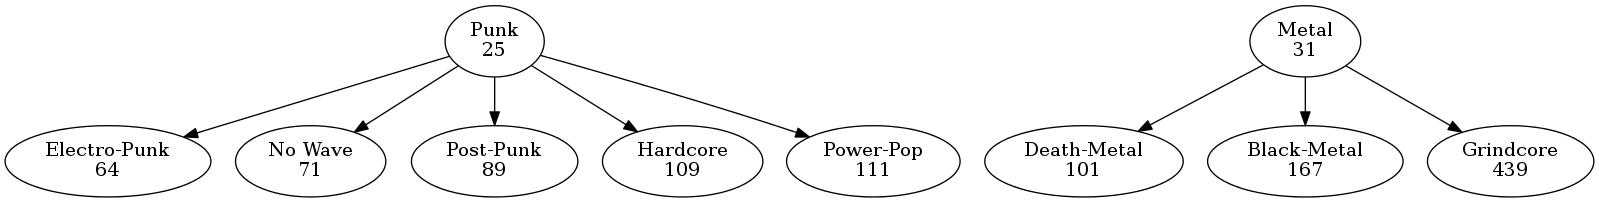

In [12]:
graph = genres.create_tree([25, 31], 1)
ipd.Image(graph.create_png())

Data cleaning: some genres returned by the archive have a `parent_id` which does not exist.

In [13]:
# 13 (Easy Listening) has parent 126 which is missing
# --> a root genre on the website, although not in the genre menu
genres.df.loc[13, 'genre_parent_id'] = 0

# 580 (Abstract Hip-Hop) has parent 1172 which is missing
# --> listed as child of Hip-Hop on the website
genres.df.loc[580, 'genre_parent_id'] = 21

# 810 (Nu-Jazz) has parent 51 which is missing
# --> listed as child of Easy Listening on website
genres.df.loc[810, 'genre_parent_id'] = 13

Save the full genre tree as a PDF.

In [14]:
roots = genres.find_roots()
print('{} roots'.format(len(roots)))
graph = genres.create_tree(roots)
graph.write_pdf('genres.pdf');

16 roots
